# Определение стоимости автомобилей

## Подготовка данных

In [53]:
# импортируем библиотеки
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from  lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [2]:
#выгружаем данные
data=pd.read_csv('/datasets/autos.csv')

In [3]:
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

Данные представлены в удобном формате. Необходимо только убрать/заменить пропуски.

In [5]:
data.isna().mean()

DateCrawled          0.000000
Price                0.000000
VehicleType          0.105794
RegistrationYear     0.000000
Gearbox              0.055967
Power                0.000000
Model                0.055606
Kilometer            0.000000
RegistrationMonth    0.000000
FuelType             0.092827
Brand                0.000000
NotRepaired          0.200791
DateCreated          0.000000
NumberOfPictures     0.000000
PostalCode           0.000000
LastSeen             0.000000
dtype: float64

Пропуси обнаружены в 5 столбцах датасета.  Количество пропусков незначительное. Все столбики обладают категориальными признаками. Необходимости заменять пропуски по категориям смысла в данном случае и этот способ может быть неверным, тем более стобец "NotRepaired", где больше всего пропусков заменить логически  никак не выйдет. Можно их просто отбросить из датасета, либо заменить на 'unknown'. Выбран был второй вариант.

In [6]:
data['VehicleType']=data['VehicleType'].fillna('unknown')
data['Gearbox']=data['Gearbox'].fillna('unknown')
data['Model']=data['Model'].fillna('unknown')
data['FuelType']=data['FuelType'].fillna('unknown')
data['NotRepaired']=data['NotRepaired'].fillna('unknown')

In [7]:
data.isna().mean()

DateCrawled          0.0
Price                0.0
VehicleType          0.0
RegistrationYear     0.0
Gearbox              0.0
Power                0.0
Model                0.0
Kilometer            0.0
RegistrationMonth    0.0
FuelType             0.0
Brand                0.0
NotRepaired          0.0
DateCreated          0.0
NumberOfPictures     0.0
PostalCode           0.0
LastSeen             0.0
dtype: float64

In [8]:
# также можно обработать столбцы с датами и убрать время. Маловероятно что оно играет роль при построенние цены. 
#Год здесь один, дни недели думаю сильного влияния на цену не оказывают в общем обьеме, оставим месяцы
#лучше данный элекмент отбросить так данные станут более сгруппированными, чем с разбивкой по секундам
data['DateCrawled'] = pd.to_datetime(data['DateCrawled'], format='%Y-%m-%d')
data['DateCreated'] = pd.to_datetime(data['DateCreated'], format='%Y-%m-%d')
data['LastSeen'] = pd.to_datetime(data['LastSeen'], format='%Y-%m-%d')
data['DateCrawled']=pd.DatetimeIndex(data['DateCrawled']).month
data['DateCreated']=pd.DatetimeIndex(data['DateCreated']).month
data['LastSeen']=pd.DatetimeIndex(data['LastSeen']).month
data

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,3,480,unknown,1993,manual,0,golf,150000,0,petrol,volkswagen,unknown,3,0,70435,4
1,3,18300,coupe,2011,manual,190,unknown,125000,5,gasoline,audi,yes,3,0,66954,4
2,3,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,unknown,3,0,90480,4
3,3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,3,0,91074,3
4,3,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,3,0,60437,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354364,3,0,unknown,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes,3,0,2694,3
354365,3,2200,unknown,2005,unknown,0,unknown,20000,1,unknown,sonstige_autos,unknown,3,0,39576,4
354366,3,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,3,0,26135,3
354367,3,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,3,0,87439,4


In [9]:
# проанализируем данные на предмет наличие страннных значений

data.describe()

,DateCrawled,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,DateCreated,NumberOfPictures,PostalCode,LastSeen
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000,354369.000000
mean,3.162387,4416.656776,2004.234448,110.094337,128211.172535,5.714645,3.160189,0.0,50508.689087,3.564987
std,0.368806,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.376284,0.0,25783.096248,0.495759
min,3.000000,0.000000,1000.000000,0.000000,5000.000000,0.000000,1.000000,0.0,1067.000000,3.000000
25%,3.000000,1050.000000,1999.000000,69.000000,125000.000000,3.000000,3.000000,0.0,30165.000000,3.000000
50%,3.000000,2700.000000,2003.000000,105.000000,150000.000000,6.000000,3.000000,0.0,49413.000000,4.000000
75%,3.000000,6400.000000,2008.000000,143.000000,150000.000000,9.000000,3.000000,0.0,71083.000000,4.000000
max,4.000000,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,12.000000,0.0,99998.000000,4.000000


- В колонке года регистрации минимальные и максимальные значения подозрительные.
- В цене есть 0 значения. 
- Колонка силы имеет 0 значения, что не являются репрезентативными, вряд ли владельцы хотят поддержанные неработающие машины, равно как и наличие машин с 20 000 лошадинными силами. 
- Месяц регитсрации  содержит 0 значение, чего не может быть. 
- Колонка с количеством фотографий содержит только лишь 0 ее лучше вовсе убрать.

In [10]:
#Найдем артефактыные значения по году

data.query('2020<RegistrationYear or RegistrationYear<1900')

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
622,3,0,unknown,1111,unknown,0,unknown,5000,0,unknown,opel,unknown,3,0,44628,3
12946,3,49,unknown,5000,unknown,0,golf,5000,12,unknown,volkswagen,unknown,3,0,74523,4
15147,3,0,unknown,9999,unknown,0,unknown,10000,0,unknown,sonstige_autos,unknown,3,0,32689,3
15870,4,1700,unknown,3200,unknown,0,unknown,5000,0,unknown,sonstige_autos,unknown,4,0,33649,4
16062,3,190,unknown,1000,unknown,0,mondeo,5000,0,unknown,ford,unknown,3,0,47166,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
340548,4,0,unknown,3500,manual,75,unknown,5000,3,petrol,sonstige_autos,unknown,4,0,96465,4
340759,4,700,unknown,1600,manual,1600,a3,150000,4,petrol,audi,no,4,0,86343,4
341791,3,1,unknown,3000,unknown,0,zafira,5000,0,unknown,opel,unknown,3,0,26624,4
348830,3,1,unknown,1000,unknown,1000,unknown,150000,0,unknown,sonstige_autos,unknown,3,0,41472,4


Данные строки нужно убрать, их число не велико в отношении общей выборке, половина данных отсутвует или не соотвествует действительности.

In [11]:
# создадим новую дату, исключив данные строки

data = data.query('2020>=RegistrationYear and RegistrationYear>1900')

In [12]:
# проверяем ценовые значения, по максимуму сложно судить, но отсекающем критерием сделаем сделки равные 5 и менее евро

data.query('Price<=5')


,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
7,3,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,3,0,19348,3
40,3,0,unknown,1990,unknown,0,corsa,150000,1,petrol,opel,unknown,3,0,56412,3
59,3,1,suv,1994,manual,286,unknown,150000,11,unknown,sonstige_autos,unknown,3,0,53721,4
89,3,1,sedan,1995,manual,113,e_klasse,150000,4,gasoline,mercedes_benz,no,3,0,40589,4
111,3,0,unknown,2017,manual,0,golf,5000,12,petrol,volkswagen,unknown,3,0,21698,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354205,3,0,unknown,2000,manual,65,corsa,150000,0,unknown,opel,yes,3,0,23758,3
354238,3,0,small,2002,manual,60,fiesta,150000,3,petrol,ford,unknown,3,0,33659,4
354248,3,0,small,1999,manual,53,swift,150000,3,petrol,suzuki,unknown,3,0,42329,4
354277,3,0,small,1999,manual,37,arosa,150000,7,petrol,seat,yes,3,0,22559,3


In [13]:
#количество сделок не значительно, также их отсекаем

data = data.query('Price>5')

In [14]:
#проверим теперь колонку мощности автомобилей

data.query('Power== 0 or Power>5000')

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,3,480,unknown,1993,manual,0,golf,150000,0,petrol,volkswagen,unknown,3,0,70435,4
15,3,450,small,1910,unknown,0,ka,5000,0,petrol,ford,unknown,3,0,24148,3
32,3,245,sedan,1994,unknown,0,golf,150000,2,petrol,volkswagen,no,3,0,44145,3
37,3,1500,unknown,2016,unknown,0,kangoo,150000,1,gasoline,renault,no,3,0,46483,3
54,3,4700,wagon,2005,manual,0,signum,150000,0,unknown,opel,no,3,0,88433,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354336,3,3299,unknown,2005,auto,0,outlander,150000,4,petrol,mitsubishi,unknown,3,0,17034,3
354338,3,180,unknown,1995,unknown,0,unknown,125000,3,petrol,opel,unknown,3,0,41470,4
354346,3,2600,unknown,2005,auto,0,c_klasse,150000,9,unknown,mercedes_benz,unknown,3,0,61169,3
354363,3,1150,bus,2000,manual,0,zafira,150000,3,petrol,opel,no,3,0,26624,3


In [15]:
# аналогично избавляемся

data = data.query('Power>0 and Power<5000')

In [16]:
# проверяем последний артефакт

data.query('RegistrationMonth== 0')

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
9,3,999,small,1998,manual,101,golf,150000,0,unknown,volkswagen,unknown,3,0,27472,3
16,4,300,unknown,2016,unknown,60,polo,150000,0,petrol,volkswagen,unknown,4,0,38871,4
36,3,1600,other,1991,manual,75,kadett,70000,0,unknown,opel,unknown,3,0,2943,4
80,4,250,wagon,2000,manual,155,156,150000,0,petrol,alfa_romeo,yes,4,0,8396,4
92,3,250,unknown,2000,unknown,60,ka,150000,0,unknown,ford,unknown,3,0,51427,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354260,3,399,other,1994,unknown,1103,3er,150000,0,unknown,bmw,unknown,3,0,56235,3
354297,3,400,wagon,1996,manual,150,a4,150000,0,petrol,audi,unknown,3,0,85110,3
354326,3,1300,small,1999,manual,75,2_reihe,125000,0,unknown,peugeot,unknown,3,0,35102,4
354329,3,350,small,1996,unknown,65,punto,150000,0,unknown,fiat,unknown,3,0,25436,4


В данном случае критичного здесь ничего нет. 0 месяц будет по логике будет как 'unknown'

In [17]:
# убираем бесполезную 0 колонку

data = data.drop('NumberOfPictures', axis=1)

In [18]:
#обрабатываем прямым кодированием
data_new = pd.get_dummies(data, drop_first=True)

In [19]:
# для новых данных сделаем отдельные выборки и проведем масштабирование признаков
features_new = data_new.drop('Price', axis=1)
target_new = data_new['Price']

train_features_new, test_features_new, train_target_new, test_target_new = train_test_split(features_new, target_new, random_state=100, test_size=0.25)


In [20]:
numeric = ['RegistrationYear', 'Power', 'Kilometer', 'RegistrationMonth', 'PostalCode']
scale = StandardScaler()
scale.fit(train_features_new[numeric])

train_features_new[numeric] = scale.transform(train_features_new[numeric])
test_features_new[numeric]= scale.transform(test_features_new[numeric])

/tmp/ipykernel_74/4124068595.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_features_new[numeric] = scale.transform(train_features_new[numeric])
/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
/tmp/ipykernel_74/4124068595.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

Пропуски устранены. Сами данные раздлены на выборки и готовы к дальнейшей работе с различными моделями.

## Обучение моделей

In [21]:
#обучим три модели: Модель, предсказывающая медиану, Линейную регрессию, Случайный лес и Градиентный бустинг
# создадим простую модель

class simple_model:
    def fit(self, train_features_new, train_target_new):
        self.median = train_target_new.median()
        
        
    def predict(self, test_features_new):
        x = pd.Series(self.median, index=test_features_new.index)
        return x


simple_model= simple_model()

In [22]:
%%time

simple_model.fit(train_features_new, train_target_new)

CPU times: user 5.52 ms, sys: 260 µs, total: 5.78 ms
Wall time: 5.34 ms


Данная модель обучается очень быстро всего лишь 7 милисекунд.

In [23]:
#модель линейной регрессии
model_linear = LinearRegression()

In [24]:
%%time
model_linear.fit(train_features_new, train_target_new)

CPU times: user 32 s, sys: 34.9 s, total: 1min 6s
Wall time: 1min 6s


LinearRegression()

Тут уже более затратная работа более полминуты, машина явно думала:)

In [25]:
# переходим к модели случайного леса
model_forest = RandomForestRegressor(random_state=100, n_estimators=50,max_depth=7)

#Пытался через GridSearchCV подобрать, но очень сильно зависает либо там многочасовой просчет(, пришлось вручную

In [26]:
%%time
model_forest.fit(train_features_new, train_target_new)

CPU times: user 2min 15s, sys: 0 ns, total: 2min 15s
Wall time: 2min 16s


RandomForestRegressor(max_depth=7, n_estimators=50, random_state=100)

In [58]:
imp_forest = pd.Series(model_forest.feature_importances_, index = train_features_new.columns)
imp_top_forest = imp.sort_values(ascending=False).head(10)
imp_top_forest

RegistrationYear           0.563741
Power                      0.320169
Kilometer                  0.081064
VehicleType_convertible    0.011869
Model_transporter          0.009743
VehicleType_unknown        0.006533
NotRepaired_yes            0.002120
FuelType_gasoline          0.001229
Brand_volkswagen           0.000670
Model_sl                   0.000312
dtype: float64

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

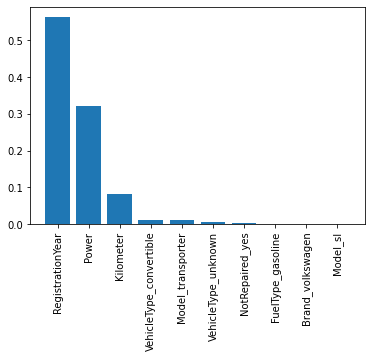

In [59]:
# Главными факторами вляющими на цену оказались год выпуска,мощность, пробег, что не удивительно. 
#Построим график топ 10 важных признаков
plt.figsize=(30,20)
plt.bar(imp_top_forest.index, imp_top_forest)
plt.xticks(rotation=90)

Лесу потребовалось более двух минут времени для обучения

In [27]:
#теперь обучим последнюю модель градиентного бустинга

lgbm_model = LGBMRegressor(n_estimators = 50, max_depth=7, min_child_samples=3)


In [28]:
%%time
lgbm_model.fit(train_features_new, train_target_new)

CPU times: user 1min 5s, sys: 366 ms, total: 1min 6s
Wall time: 1min 6s


LGBMRegressor(max_depth=7, min_child_samples=3, n_estimators=50)

На обучение здесь ушло аналогичное время как у линейной регрессии

In [60]:
# узнаем мнение модели градиентного бустинга касательно важности фаткоров
imp_lgbm = pd.Series(lgbm_model.feature_importances_, index = train_features_new.columns)
imp_top_lgbm = imp.sort_values(ascending=False).head(10)
imp_top_lgbm

RegistrationYear           0.563741
Power                      0.320169
Kilometer                  0.081064
VehicleType_convertible    0.011869
Model_transporter          0.009743
VehicleType_unknown        0.006533
NotRepaired_yes            0.002120
FuelType_gasoline          0.001229
Brand_volkswagen           0.000670
Model_sl                   0.000312
dtype: float64

Мнения двух моделей а важности совпадают график стоить уже не будем.

## Анализ моделей

Проведем предсказания и посчитаем метрику MSE для каждой модели


In [29]:
%%time
predict_simple = simple_model.predict(test_features_new)

CPU times: user 1.19 ms, sys: 0 ns, total: 1.19 ms
Wall time: 1.2 ms


Модель предсказала также бысто, как и обучалась.

In [30]:
print('MSE:', mean_squared_error(test_target_new, predict_simple))
print('RMSE:', (mean_squared_error(test_target_new, predict_simple))**0.5)

MSE: 23557576.552441254
RMSE: 4853.6147923420185


Такая модель всреднем ошибается на 5000 рублей по цене. Проверим другие.

In [31]:
%%time
predict_linear = model_linear.predict(test_features_new)

CPU times: user 74.9 ms, sys: 68.1 ms, total: 143 ms
Wall time: 92.3 ms


Предсказала модель тоже очень быстро. Проверим метрики.

In [32]:
print('MSE:', mean_squared_error(test_target_new, predict_linear))
print('RMSE:', (mean_squared_error(test_target_new, predict_linear))**0.5)

MSE: 7200285.915136034
RMSE: 2683.3348496108406


Тут уже лучше результат эта модель ошибается на более 2,6 тысячи рублей всреднем.

In [33]:
%%time
predict_forest = model_forest.predict(test_features_new)

CPU times: user 252 ms, sys: 56.3 ms, total: 309 ms
Wall time: 307 ms


У этой модели предсказание уже чуть медление, провда речь о милисекундах.

In [34]:
print('MSE:', mean_squared_error(test_target_new, predict_forest))
print('RMSE:', (mean_squared_error(test_target_new, predict_forest))**0.5)

MSE: 4543746.44814149
RMSE: 2131.6065415881726


Ошибка еще снизилась на практически на половину тысячи рублей. Проверим последнюю модель

In [35]:
%%time
lgbm_predict = lgbm_model.predict(test_features_new)

CPU times: user 511 ms, sys: 71.2 ms, total: 582 ms
Wall time: 573 ms


Предсказание получилось в два раза дольше, чем у леса

In [36]:
print('MSE:', mean_squared_error(test_target_new, lgbm_predict))
print('RMSE:', (mean_squared_error(test_target_new, lgbm_predict))**0.5)

MSE: 3116912.6461746846
RMSE: 1765.4780220027335


Метрики улучшились еще. Ошибка всреднем составляет менее 2 тысяч рублей. 

Таким образом, самой эффективной моделью оказалась модель градиентного бустинга. Но из всех изученных моделей она оказалась и самой медленной при формировании предсказания. Как показало исследование более быстрые модели склоны чаще ошибаться, медленные модели наоборот имеют меньше ошибок. Тут как обычно встает главный вопрос соотношения скорости и качества. Если на предсказаниях различия скорости не так бросаются в глаза, то на стадии обучения моделей это более заметно, хотя модель градиентного бустинга смогла обучиться быстрее леса. Все же рекомендовано использовать модель градиентного бустинга, не смотря на ее медлительность при предсказаниях.

In [67]:
name = ['Простая_модель', 'Линейная_регрессия', 'Случайный_лес', 'Градиентный_бустинг']

columns = ['Качество_метрики_RSME(rub.)', 'Скорость_обучения(s.)', 'Скорость_предсказания(ms.)']

results = [[4853, 0.00578, 1.2],
          [2683, 66, 143],
          [2131, 135, 309],
          [1765, 66, 582]]

display(pd.DataFrame(results, index=name, columns=columns))

,Качество_метрики_RSME(rub.),Скорость_обучения(s.),Скорость_предсказания(ms.)
Простая_модель,4853,0.00578,1.2
Линейная_регрессия,2683,66.00000,143.0
Случайный_лес,2131,135.00000,309.0
Градиентный_бустинг,1765,66.00000,582.0
